In [1]:
# Probability of default is the liklihood that someone will default on a loan
# it is a value between 0 and 1 - high value indicates they are more likely to default
# Loan status of 0 is no default and 1 is default

# logistic Regression and Decision trees will be used

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, precision_recall_fscore_support, roc_auc_score, confusion_matrix, accuracy_score

In [3]:
df = pd.read_csv('credit_risk_dataset_clean.csv')

In [25]:
# no missing values
df.isna().sum().any()

False

In [5]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


# Data Preprocessing
### Creating Dummy Variables, isolating feature and target variables, splitting into train and test sets

In [6]:
# creating dummy variables
df = pd.get_dummies(df)

In [7]:
# checking that dummy variable creation worked
for column in df.columns:
    print(column)

person_age
person_income
person_emp_length
loan_amnt
loan_int_rate
loan_status
loan_percent_income
cb_person_cred_hist_length
person_home_ownership_MORTGAGE
person_home_ownership_OTHER
person_home_ownership_OWN
person_home_ownership_RENT
loan_intent_DEBTCONSOLIDATION
loan_intent_EDUCATION
loan_intent_HOMEIMPROVEMENT
loan_intent_MEDICAL
loan_intent_PERSONAL
loan_intent_VENTURE
loan_grade_A
loan_grade_B
loan_grade_C
loan_grade_D
loan_grade_E
loan_grade_F
loan_grade_G
cb_person_default_on_file_N
cb_person_default_on_file_Y


In [8]:
# Predictor X is all of our features used to predict y, our loan status target variable
feature_variables = df.drop('loan_status', axis=1).columns
X = df.drop('loan_status', axis=1).values
y = df['loan_status'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Modeling
### Logistic Regression

In [10]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression()

In [11]:
# making predictions
# Uses threshold of 0.5
pred_prob = log_reg.predict_proba(X_test)
df_probs = pd.DataFrame(pred_prob,columns = ['prob_non_default','prob_default'])
df_probs['loan_status_pred'] = df_probs['prob_default'].apply(lambda x: 1 if x >= 0.5 else 0)
df_probs['loan_status_actual'] = y_test

In [12]:
df_probs.head()

,prob_non_default,prob_default,loan_status_pred,loan_status_actual
0,0.799648,0.200352,0,0
1,0.773686,0.226314,0,0
2,0.945506,0.054494,0,0
3,0.537544,0.462456,0,1
4,0.748257,0.251743,0,0


### Evaluating model - Logistic Regression

In [13]:
# Checking Accuracy of model
print(f"Model Accuracy: {log_reg.score(X_test,y_test)}")

Model Accuracy: 0.8079161816065192


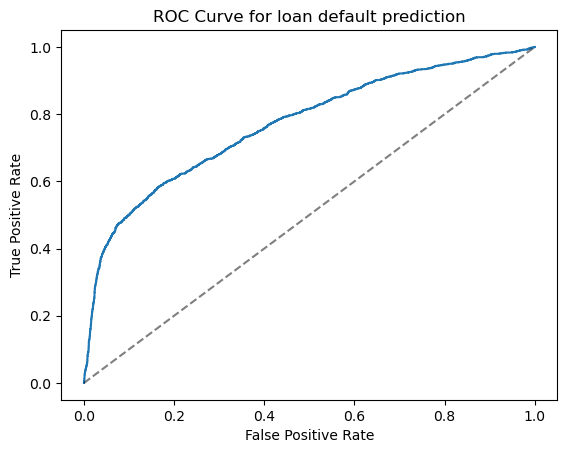

In [14]:
# Plotting ROC curve
fpr, tpr, thresholds = roc_curve(y_test, df_probs['prob_default'].values)
plt.plot(fpr, tpr)
plt.title('ROC Curve for loan default prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.show()

In [15]:
# Getting the AUC score - area under the curve
print(f"AUC Score: {roc_auc_score(y_test, df_probs['prob_default'].values)}")

AUC Score: 0.7696762284833552


In [16]:
print(classification_report(y_test, df_probs['loan_status_pred'], target_names=['non-default','default']))

              precision    recall  f1-score   support

 non-default       0.81      0.98      0.89      6731
     default       0.75      0.17      0.27      1859

    accuracy                           0.81      8590
   macro avg       0.78      0.58      0.58      8590
weighted avg       0.80      0.81      0.76      8590



In [17]:
# you can select an individual value from the classification report by using this:
recall_default = precision_recall_fscore_support(df_probs['loan_status_actual'], df_probs['loan_status_pred'])[1][1]
print(recall_default)
#[1][1] is the location of the value in our report ^ for 'recall' column and 'default' row

# This is bad because it means we correctly predicted only 16%  of defaults

0.16729424421732114


In [18]:
# Confusion Matrix
print(confusion_matrix(y_test, df_probs['loan_status_pred']))

# order is as follows
# [ True Neg   False Pos ]
# [ FalseNeg   True  Pos ]

[[6629  102]
 [1548  311]]


### Estimating loss with different thresholds - Logistic Regression


In [19]:
thresholds = [round(i, 2) for i in np.arange(0.2, 0.75, 0.05)]

def_recalls = []
non_def_recalls = []
accs = []
est_losses = []

for threshold in thresholds:
    #creating new column based on thresholds
    df_probs['loan_status_pred'] = df_probs['prob_default'].apply(lambda x: 1 if x >= threshold else 0)
    #gathering default recall, non-default recall, and accuracy at each threshold
    def_recalls.append(precision_recall_fscore_support(df_probs['loan_status_actual'], df_probs['loan_status_pred'])[1][1])
    non_def_recalls.append(precision_recall_fscore_support(df_probs['loan_status_actual'], df_probs['loan_status_pred'])[0][1])
    accs.append(accuracy_score(df_probs['loan_status_actual'], df_probs['loan_status_pred']))
    #estimating loss
    num_pred_defaults = df_probs['loan_status_pred'].sum()
    default_recall = precision_recall_fscore_support(df_probs['loan_status_actual'], df_probs['loan_status_pred'])[1][1]
    avg_loan_amnt = df['loan_amnt'].mean()
    est_losses.append((avg_loan_amnt * num_pred_defaults) * (1 - default_recall))


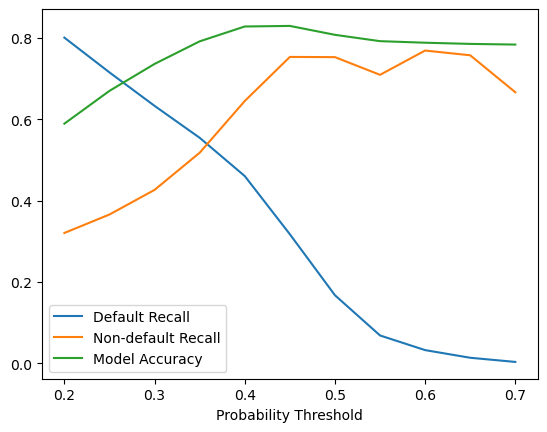

In [20]:
plt.plot(thresholds,def_recalls)
plt.plot(thresholds,non_def_recalls)
plt.plot(thresholds,accs)
plt.xlabel("Probability Threshold")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

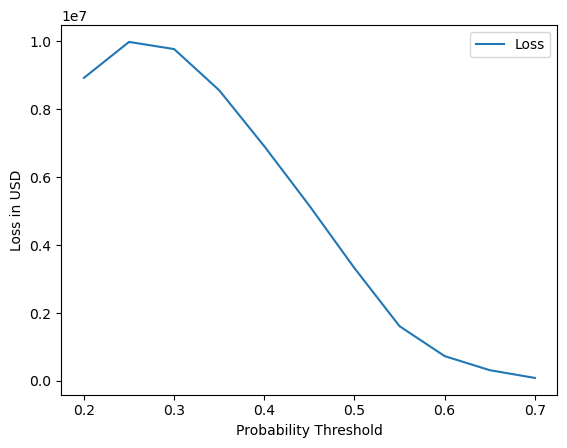

In [21]:
plt.plot(thresholds,est_losses)
plt.xlabel('Probability Threshold')
plt.ylabel('Loss in USD')
plt.legend(['Loss'])
plt.show()

In [22]:
# Feature weights
feature_coefs = dict(zip(feature_variables, log_reg.coef_[0]))
for feature, coef in feature_coefs.items():
    print(f"Feature: {feature}")
    print(f"Coeff:   {coef}\n")

Feature: person_age
Coeff:   -6.915497697592514e-08

Feature: person_income
Coeff:   -3.951503327967029e-05

Feature: person_emp_length
Coeff:   -2.6227913783202977e-08

Feature: loan_amnt
Coeff:   0.0001025252281355254

Feature: loan_int_rate
Coeff:   9.02449299792548e-08

Feature: loan_percent_income
Coeff:   2.38978317310965e-09

Feature: cb_person_cred_hist_length
Coeff:   -1.1000412393440612e-08

Feature: person_home_ownership_MORTGAGE
Coeff:   -6.171270682837602e-09

Feature: person_home_ownership_OTHER
Coeff:   9.833768025784598e-12

Feature: person_home_ownership_OWN
Coeff:   -3.881377448990854e-09

Feature: person_home_ownership_RENT
Coeff:   7.327002525162828e-09

Feature: loan_intent_DEBTCONSOLIDATION
Coeff:   2.3329213271180744e-09

Feature: loan_intent_EDUCATION
Coeff:   -3.2216800211120435e-09

Feature: loan_intent_HOMEIMPROVEMENT
Coeff:   1.8585121550265602e-09

Feature: loan_intent_MEDICAL
Coeff:   1.214107124941608e-09

Feature: loan_intent_PERSONAL
Coeff:   -1.0728205

In [23]:
# Model Parameters
for key, value in log_reg.get_params().items():
    print(f'{key}: {value}')

C: 1.0
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: None
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False


In [24]:
# Model Intercept
model_intercept = log_reg.intercept_[0]
print(model_intercept)

-2.7158118386484236e-09
